In [1]:
import pandas as pd
import numpy as np
from plotly_dataframe import plot 
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from model_selection import rolling_window_validation
from SVM import SVM
from metrics import metrics
import os
import shutil
from plotly_plt_predictions import plot_predictions
from tqdm import tqdm
from ipywidgets import widgets, interact
import matplotlib.pyplot as plt
from plot_map import choropleth
from IPython.display import clear_output, display

# Forecasting - Food Consumption Score (FCS)

In [2]:
# Load the original data of the second version of fcs indicator released by wfp.
df = pd.read_csv("../../../Data Sources/Food Consumption Score (FCS)/time-series/Yemen/wfp_fcs-v2-daily-interpolate.csv", header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq
df.columns.names = ["AdminStrata", "Indicator"]
df.head()

AdminStrata,Abyan,Aden,Al Bayda,Al Dhale'e,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amanat Al Asimah,Amran,...,Hadramaut,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'ada,Sana'a,Shabwah,Taizz
Indicator,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,...,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-02,31.158690,16.619519,38.332669,29.194825,20.788151,22.085706,2.892308,16.815145,17.000398,20.446735,...,23.822825,28.361345,25.036668,31.762436,32.596233,54.121774,17.676022,26.917713,16.752289,26.563365
2018-07-03,32.675222,16.370603,43.292084,31.336940,20.692544,23.477196,2.913825,19.833443,17.208166,21.689014,...,23.699881,28.805448,27.102390,32.049499,33.333333,56.722689,17.134560,25.783476,18.257453,29.124005
2018-07-04,33.415597,15.089163,45.128205,33.135157,21.825051,24.864000,2.950408,19.614289,18.070801,25.611124,...,23.103187,30.993706,29.844066,33.106267,36.883683,56.306306,17.454545,25.436047,19.083081,29.427973
2018-07-05,33.531451,15.766521,43.959297,34.554309,21.481693,27.814992,2.247913,19.558566,19.021964,27.922484,...,21.596419,32.905902,29.025363,32.938828,36.897633,56.231003,17.846350,27.421759,20.349533,30.456026
2018-07-06,33.951856,16.870065,44.516521,33.878557,21.076712,28.688245,2.269780,17.608130,19.817567,28.712235,...,20.129084,32.598181,30.692766,33.837934,36.669568,57.324841,18.463057,26.547231,21.107524,31.012517


In [3]:
#plot(fcs, title = "FCS indicator", yaxis = "% of people with poor and borderline FCS", style = "lines")

In [4]:
# Define the desired length of the test set.
TEST = 30
# Define the metric to evaluate the model.
ERROR = "MSE"
# Set boolean parameter to perform an optional grid search.
GRID_SEARCH = True

In [5]:
# Define the training set and the test set.
train = df[:-TEST]  
test = df[-TEST:]

In [13]:
# Create workspace.
dir = "./output"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)           
    os.makedirs(dir)
    
os.makedirs(dir + "/images")
os.makedirs(dir + "/grid_search")

# Create a txt file where I annotate the above chosen parameters.
with open(dir + "/setting.txt", "w") as f:
    f.write("GRID SEARCH: %s \n" % GRID_SEARCH)
    f.write("TEST: %d \n" % TEST)
    f.write("ERROR: %s \n" % ERROR)

# Support Vector Machine (SVM) model

SVM models have a similar structure to ANN, but differ in how the learning is conducted. While ANN work by minimizing the empirical risk, i.e., the error minimization of the induced model on the training data, SVM are grounded on the principle of structural risk minimization, which seeks the lowest training error while minimizing an upper bound on the generalization error of the model (model error when applied to test data).

# Optional grid search

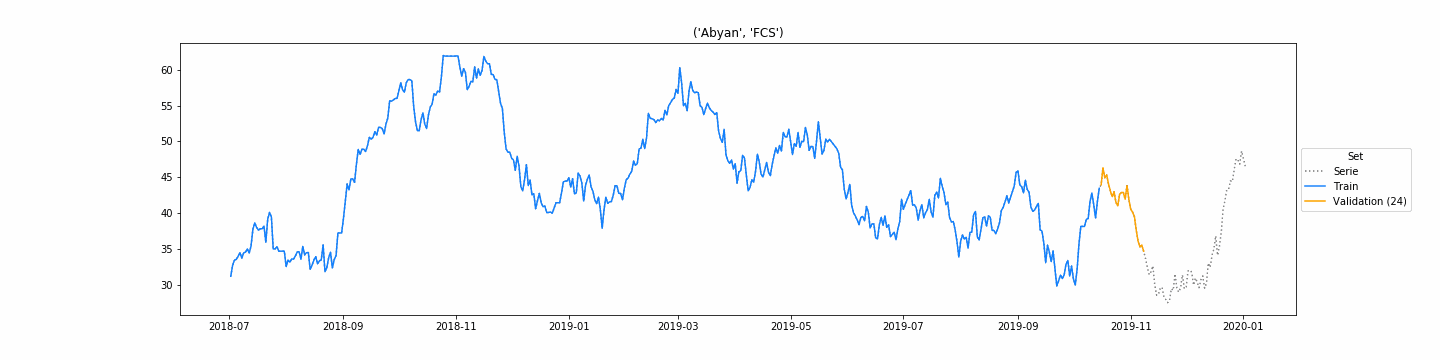

In [14]:
# Define the parameters to grid search.
if GRID_SEARCH:
    validation_type = rolling_window_validation(k_folds = 3, validation_size = 0.05, gap = 0.9, TimeSeriesSplit = False)
    # Show the validation type keeping the first column (time-series).
    _ = validation_type.get_splits(train[train.columns[0]], show = True, path = dir)
    space = {"l": hp.randint("l", 3, 200),
             "C": hp.uniform("C", 1e-5, 1), 
             "gamma": hp.uniform("gamma", 0.005, 0.999),
             "standardization": hp.choice("standardization", [True, False])
            }
else:
    space = {"l": 4,
             "C": 0.8, 
             "gamma": 0.3,
             "standardization": False
            }

In [15]:
def hyperparameters(space, group):
    adminstrata = group.name
    try:
        losses = list()
        for tr, val in validation_type.get_splits(group, show = False):  
            # Define model.
            model = SVM(l = int(space["l"]), C = space["C"], gamma = space["gamma"], standardization = space["standardization"], 
                        h = len(val))
            # Coumpute prediction on this fold.
            pred = model.predict(tr)
            error = metrics(val, pred, ERROR).compute()
            losses.append(error)

        # Compute mean of the fold errors.
        error = np.mean(losses)

        # Recursive save results.
        space["loss"] = error
        df_space = pd.DataFrame(space, index = [0])
        filename = dir + "/grid_search/" + adminstrata + ".csv"
        df_space.to_csv(filename, index = False, header = (not os.path.exists(filename)), mode = "a")
    except:
        error = np.inf

    return {"loss": error, "status": STATUS_OK}

In [16]:
def GridSearch(group):
    adminstrata = group.name
    print("Grid search for adminstrata:", adminstrata)
    # The searching of the best minimum combination of parameters.
    trials = Trials()
    best = fmin(fn = lambda x: hyperparameters(x, group),
                space = space,
                algo = tpe.suggest,
                max_evals = 1000, 
                trials = trials, 
                verbose = True)      
    clear_output(wait = True)
    return best

In [17]:
def NoGridSearch(group):
    adminstrata = group.name
    space["loss"] = 0
    df_space = pd.DataFrame(space, index = [0])
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    df_space.to_csv(filename, index = False)

In [18]:
if GRID_SEARCH:    
    _ = train.groupby(level = 0, axis = 1).apply(GridSearch)
else:
    _ = train.groupby(level = 0, axis = 1).apply(NoGridSearch)

Grid search for adminstrata: Taizz
100%|████████████████████████████████████████████| 1000/1000 [09:01<00:00,  1.85trial/s, best loss: 14.205343055569083]


# Forecasting

In [19]:
figures = dict()
df_prediction = dict()

In [20]:
def forecast(group):
    adminstrata = group.name
    # Reduce the group dataframe to simple serie.
    serie = group[adminstrata]["FCS"]
    # Load the parameters.
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    params = pd.read_csv(filename)
    best_params = params.loc[params.loss.idxmin()]  
    # Prediction.
    model = SVM(l = int(best_params["l"]), C = best_params["C"], gamma = best_params["gamma"], 
                standardization = best_params["standardization"], h = TEST)
    predicted = model.predict(serie)
    
    # Define the entire original FCS time-series: train + test.
    original = pd.concat([serie, test[adminstrata]["FCS"]])
    # Plot of the prediction.
    figure = plot_predictions(original, predicted, title = adminstrata, plotly = False, 
                              save = True, dir_to_save = dir + "/images/")
    
    # Store into dictionary.
    figures[adminstrata] = figure
    df_prediction[adminstrata] = predicted
    
    error = metrics(test[adminstrata]["FCS"], predicted, ERROR).compute()
    
    return error

In [21]:
tqdm.pandas()
errors = train.groupby(level = 0, axis = 1).progress_apply(forecast)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.61it/s]


In [22]:
errors.mean()

30.70590026537813

In [23]:
def plot_prediction(name):
    fig = figures[name]
    display(fig)

In [24]:
w = widgets.Dropdown(options = df.columns.get_level_values(0).unique(), description = df.columns.get_level_values(0).name, 
                     disabled = False)
p = interact(plot_prediction, name = w)

interactive(children=(Dropdown(description='AdminStrata', options=('Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", …

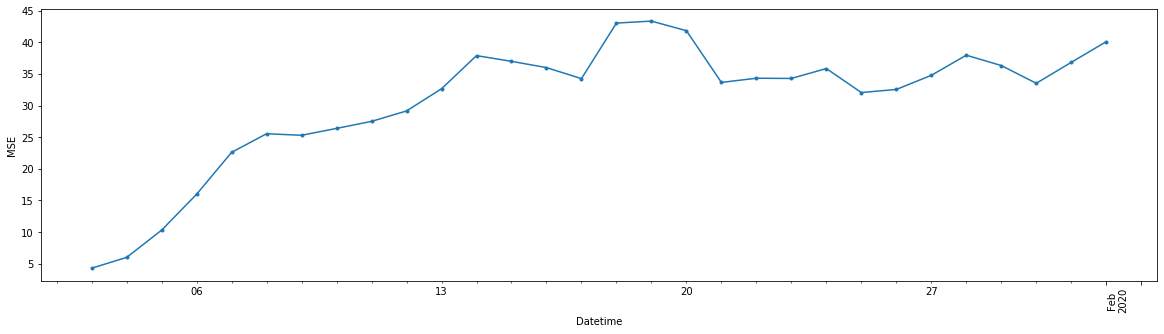

In [25]:
# Plot the mean error in function of the time.
def error_time(serie):
    date = serie.name
    pred_time = pd.DataFrame(df_prediction).transpose()[date]
    error = metrics(serie, pred_time, ERROR).compute()
    return error
    
prediction_time = test.transpose().apply(error_time)

# Show plot.
f = plt.figure(figsize = (20, 5))
prediction_time.plot(ax = f.gca(), style = ".-")
plt.ylabel(ERROR)
plt.xlabel("Datetime")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

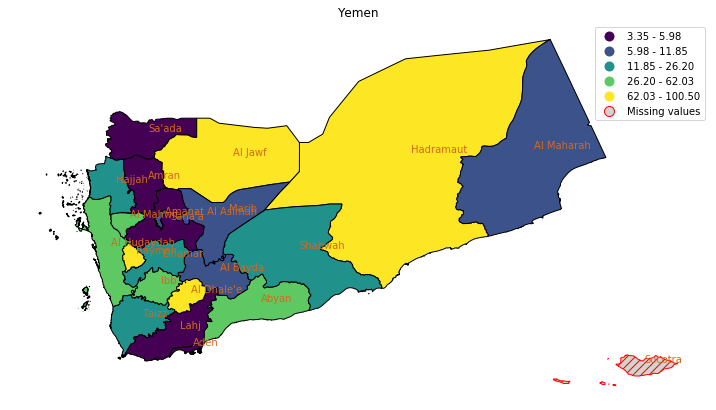

In [26]:
choropleth("Yemen", df.columns.get_level_values(0).unique(), errors, annotation = True, figsize = (15, 7))

In [27]:
# Save the results dataframe.
predictions = pd.DataFrame(df_prediction)
predictions.columns = pd.MultiIndex.from_product([predictions.columns, ["FCS"]])
predictions.columns.names = ["AdminStrata", "Indicator"]

In [28]:
test.to_csv(dir + "/test.csv")
predictions.to_csv(dir + "/SVM.csv")